In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
train = pd.read_csv('dataset/train.csv')

In [3]:
train.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [4]:
train['Class'].value_counts()

Miscellaneous     2801
Christmas_Tree    1539
Jacket             640
Candle             593
Airplane           535
Snowman            361
Name: Class, dtype: int64

In [5]:
img = image.load_img('dataset/train/image1008.jpg')

(80, 80, 3)


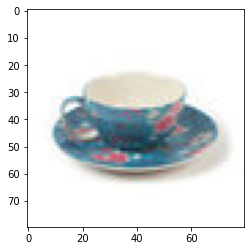

In [6]:
img = image.img_to_array(img)/255
plt.imshow(img)
print(img.shape)

<AxesSubplot:>

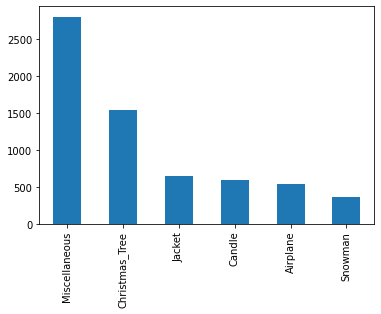

In [7]:
train['Class'].value_counts().plot.bar()

In [8]:
train_folder = 'dataset/train'
test_folder = 'dataset/test'

In [9]:
size = [299, 299]

In [10]:
train_df, test_df = train_test_split(train, test_size = .15, stratify = train.Class.values, shuffle = True)

In [11]:
train_df.reset_index(inplace = True, drop = True)
test_df.reset_index(inplace = True, drop = True)

In [12]:
train_df.head()

,Image,Class
0,image1806.jpg,Miscellaneous
1,image7658.jpg,Snowman
2,image4091.jpg,Christmas_Tree
3,image7041.jpg,Candle
4,image1631.jpg,Miscellaneous


In [13]:
train_df['Class'].value_counts()

Miscellaneous     2380
Christmas_Tree    1308
Jacket             544
Candle             504
Airplane           455
Snowman            307
Name: Class, dtype: int64

In [14]:
train_imageDataGenerate = ImageDataGenerator(rescale= 1./255, shear_range= 0.2, zoom_range= 0.2, horizontal_flip= True)
train_dataset = train_imageDataGenerate.flow_from_dataframe(dataframe = train_df, directory= train_folder,
                                                            x_col = "Image", y_col = "Class", class_mode = "categorical",
                                                            target_size= (299, 299), batch_size = 32)

Found 5498 validated image filenames belonging to 6 classes.


In [15]:
test_imageDataGenerate = ImageDataGenerator(rescale= 1./255, shear_range= 0.2, zoom_range= 0.2, horizontal_flip= True)
test_dataset = test_imageDataGenerate.flow_from_dataframe(dataframe = test_df, directory= train_folder,
                                                            x_col = "Image", y_col = "Class", class_mode = "categorical",
                                                            target_size= (299, 299), batch_size = 32)

Found 971 validated image filenames belonging to 6 classes.


In [18]:
model = InceptionResNetV2(input_shape= size + [3], weights= 'imagenet', include_top= False)
for layer in model.layers:
  layer.trainable = False

x = Flatten()(model.output)
prediction = Dense(6, activation= 'softmax')(x)
model1 = Model(inputs= model.input, outputs = prediction)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
model1.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [21]:
r = model1.fit(train_dataset, validation_data= test_dataset, epochs= 5, steps_per_epoch= train_dataset.n//32, validation_steps= test_dataset.n//32)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpg5q887qq.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpg5q887qq.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
171/171 [==============================] - 364s 1s/step - loss: 4.2503 - accuracy: 0.7183 - val_loss: 3.6750 - val_accuracy: 0.8250
Epoch 2/5
171/171 [==============================] - 155s 902ms/step - loss: 1.7588 - accuracy: 0.8711 - val_loss: 3.6870 - val_accuracy: 0.8302
Epoch 3/5
171/171 [==============================] - 157s 917ms/step - loss: 1.4280 - accuracy: 0.9109 - val_

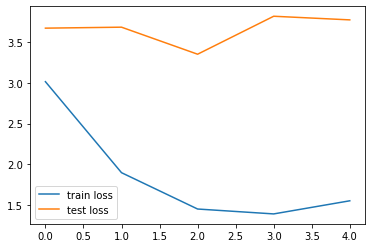

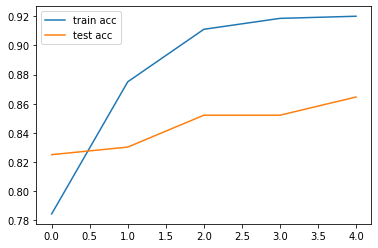

<Figure size 432x288 with 0 Axes>

In [22]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()
plt.show()
plt.savefig('Inception_LossTest_loss')

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend()
plt.show()
plt.savefig('Inception_AccTest_acc')

In [23]:
name = []
y_pred = []
labels = (train_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
for i in os.listdir('dataset/test/'):
    name.append(i)
    i='dataset/test/'+i
    img=image.load_img(i,target_size=(299,299,3))
    img=image.img_to_array(img)/255
    pred=model1.predict(img.reshape(1,299,299,3))
    y_pred.append(labels[np.argmax(pred[0])])
    
data=pd.DataFrame((zip(name,y_pred)),columns=['Image','Class'])
data.head()

,Image,Class
0,image10.jpg,Miscellaneous
1,image100.jpg,Airplane
2,image1013.jpg,Jacket
3,image1014.jpg,Miscellaneous
4,image1018.jpg,Christmas_Tree


In [24]:
data.head(50)

,Image,Class
0,image10.jpg,Miscellaneous
1,image100.jpg,Airplane
2,image1013.jpg,Jacket
3,image1014.jpg,Miscellaneous
4,image1018.jpg,Christmas_Tree
5,image1019.jpg,Miscellaneous
6,image1021.jpg,Jacket
7,image1023.jpg,Airplane
8,image1024.jpg,Miscellaneous
9,image1029.jpg,Miscellaneous


In [25]:
data.to_csv('dataset/test.csv',index=False)

In [ ]:
img = image.load_img('dataset/test/image1110.jpg')
img = image.img_to_array(img)/255
plt.imshow(img)
print(img.shape)